# FULLY GENERATED BY CHATGPT::: NEEDS SANITY CHECKING 
## Statistics & Business Statistics — Hands‑On Lab (CTP)

**Goal:** Practice core industry stats end‑to‑end on an e‑commerce style dataset: descriptive stats → distributions → sampling/CI → hypothesis testing → correlation → regression → business framing.

> ✅ You can use the provided `ecommerce_sales.csv` (synthetic but realistic), **or** swap in a real dataset (e.g., UCI Online Retail II). The notebook is written to work with either if you supply equivalent columns.

## 0) Setup

- Run the cell below to install/import packages (if needed).
- If you're using a different dataset, skim Section 1 to map/rename your columns accordingly.

In [22]:
# If running locally and you need to install:
%pip install pandas numpy scipy statsmodels matplotlib seaborn scikit-learn openpyxl

Note: you may need to restart the kernel to use updated packages.


In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Plot defaults (keep it simple and legible)
plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True

## 1) Load Data

**Option A (default):** Use the provided `ecommerce_sales.csv` (800 rows).  
**Option B (real-world):** Use a local file you downloaded (e.g., UCI Online Retail II).

> **Expected columns** (or equivalent you can map):  
> `user_id, group (A/B), ad_spend, sessions, purchases, revenue, region, signup_date`

In [24]:
# === PICK YOUR DATA SOURCE ===
CSV_PATH = "ecommerce_sales.csv"  # <- Provided synthetic dataset placed in working dir
df = pd.read_csv(CSV_PATH)
df.head()

,user_id,group,ad_spend,sessions,purchases,revenue,region,signup_date
0,1,A,5.61,2,0,0.00,Europe,2024-05-10
1,2,B,61.95,1,0,0.00,North America,2024-03-13
2,3,B,25.17,1,1,73.69,Europe,2024-05-15
3,4,B,24.39,3,0,0.00,Europe,2024-04-06
4,5,A,10.20,0,0,0.00,North America,2024-05-02


### 1.1 Sanity checks
Quick look at shape, types, missingness, and a preview.

In [25]:
df.shape, df.dtypes

((800, 8),
 user_id          int64
 group           object
 ad_spend       float64
 sessions         int64
 purchases        int64
 revenue        float64
 region          object
 signup_date     object
 dtype: object)

In [26]:
df.isna().mean().sort_values(ascending=False).head(20)

user_id        0.0
group          0.0
ad_spend       0.0
sessions       0.0
purchases      0.0
revenue        0.0
region         0.0
signup_date    0.0
dtype: float64

In [27]:
df.sample(5, random_state=1)

,user_id,group,ad_spend,sessions,purchases,revenue,region,signup_date
8,9,B,33.21,1,1,28.35,Europe,2024-02-18
510,511,B,22.84,4,0,0.00,North America,2024-03-15
175,176,A,10.92,2,0,0.00,North America,2024-04-08
735,736,B,34.11,3,0,0.00,North America,2024-04-10
242,243,B,32.84,3,0,0.00,North America,2024-01-17


## 2) Descriptive Statistics

**Tasks**
- Compute mean, median, std for `revenue`, `sessions`, `purchases`.
- Compare distributions across `region` or `group`.
- Visualize skew/outliers.

> *Why?* Before modeling, understand the data's center and spread and where outliers live.

In [28]:
metrics = ["revenue", "sessions", "purchases"]
desc = df[metrics].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).T
desc

,count,mean,std,min,25%,50%,75%,90%,95%,max
revenue,800.0,6.547325,28.212302,0.0,0.0,0.0,0.0,0.0,47.738,303.73
sessions,800.0,2.155000,1.544817,0.0,1.0,2.0,3.0,4.0,5.000,8.00
purchases,800.0,0.088750,0.305762,0.0,0.0,0.0,0.0,0.0,1.000,2.00


In [29]:

# Grouped summaries (change 'region' to any categorical column you have)
df.groupby("region")[["revenue","sessions","purchases"]].agg(["mean","median","std","count"]).round(2)

revenue                     sessions                     \
                 mean median    std count     mean median   std count   
region                                                                  
Asia             8.09    0.0  36.52   163     1.94    2.0  1.55   163   
Europe           5.86    0.0  22.33   281     2.10    2.0  1.48   281   
North America    6.38    0.0  28.07   356     2.29    2.0  1.58   356   

              purchases                     
                   mean median   std count  
region                                      
Asia               0.10    0.0  0.33   163  
Europe             0.09    0.0  0.31   281  
North America      0.08    0.0  0.29   356

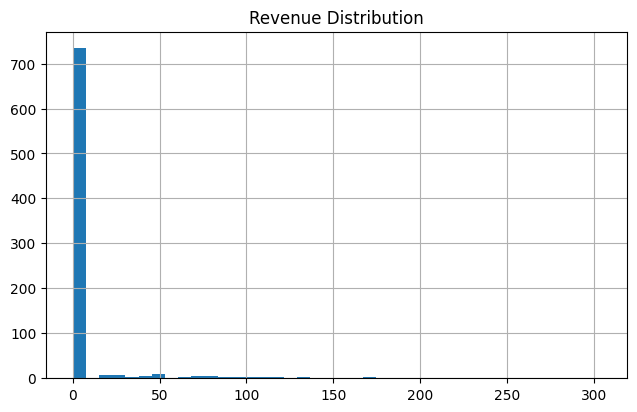

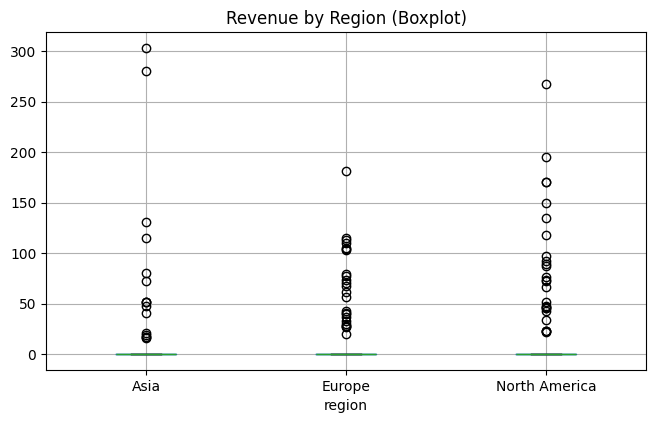

In [30]:

# Visuals: hist & boxplot to reveal skew/outliers
fig, ax = plt.subplots()
df["revenue"].hist(bins=40, ax=ax)
ax.set_title("Revenue Distribution")
plt.show()

fig, ax = plt.subplots()
df.boxplot(column="revenue", by="region", ax=ax)
ax.set_title("Revenue by Region (Boxplot)")
plt.suptitle("")
plt.show()

## 3) Distributions in Practice

**Tasks**
- Treat `purchases` as count data (Poisson-ish). Plot its distribution.
- Explore `sessions` distribution; check if long-tailed.
- (Optional) CLT demo: sample means of `revenue`.

> *Why?* Picking reasonable distributional assumptions clarifies which tests and intervals are valid.

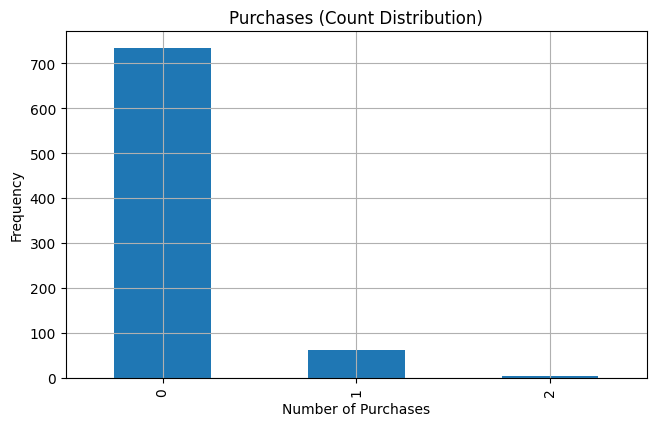

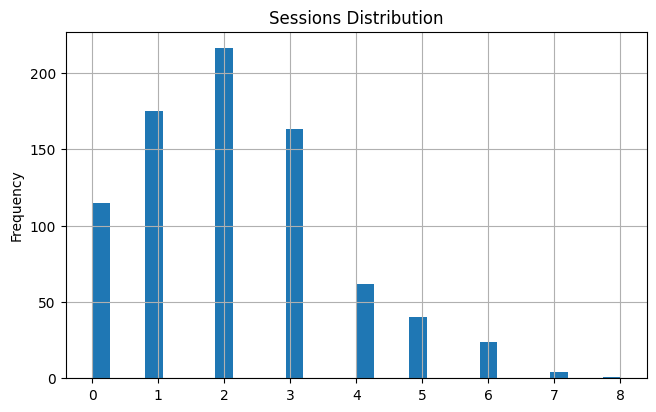

In [31]:

# Purchases distribution
fig, ax = plt.subplots()
df["purchases"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Purchases (Count Distribution)")
ax.set_xlabel("Number of Purchases")
ax.set_ylabel("Frequency")
plt.show()

# Sessions histogram
fig, ax = plt.subplots()
df["sessions"].plot(kind="hist", bins=30, ax=ax)
ax.set_title("Sessions Distribution")
plt.show()

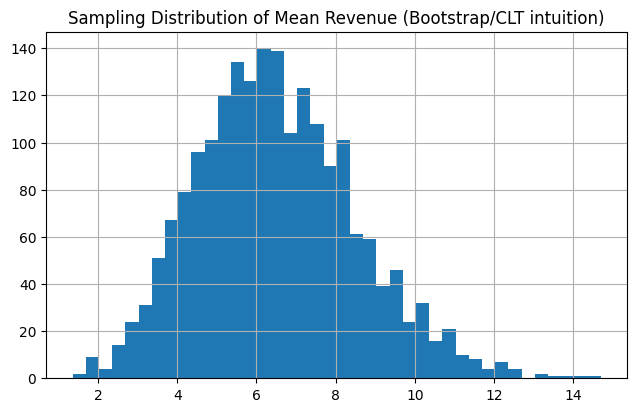

In [32]:

# (Optional) CLT demo: sample means of revenue
rng = np.random.default_rng(0)
means = [rng.choice(df["revenue"].values, size=200, replace=True).mean() for _ in range(2000)]
fig, ax = plt.subplots()
ax.hist(means, bins=40)
ax.set_title("Sampling Distribution of Mean Revenue (Bootstrap/CLT intuition)")
plt.show()

## 4) Sampling & Confidence Intervals (Bootstrap)

**Task**
- Build a 95% CI for mean `revenue`. Repeat per `region`.

> *Why?* Quantify uncertainty around your estimates.

In [33]:

def bootstrap_ci_mean(x, n_boot=5000, ci=0.95, seed=0):
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(n_boot)]
    lo = np.quantile(boots, (1-ci)/2)
    hi = np.quantile(boots, 1-(1-ci)/2)
    return lo, hi

overall_ci = bootstrap_ci_mean(df["revenue"].values, seed=1)
overall_ci

(np.float64(4.658997187500001), np.float64(8.653314062499993))

In [34]:

region_cis = (
    df.groupby("region")["revenue"]
      .apply(lambda s: pd.Series(bootstrap_ci_mean(s.values, seed=42), index=["ci_lo","ci_hi"]))
      .round(2)
)
region_cis

region              
Asia           ci_lo     3.43
               ci_hi    14.33
Europe         ci_lo     3.46
               ci_hi     8.68
North America  ci_lo     3.69
               ci_hi     9.58
Name: revenue, dtype: float64

## 5) Hypothesis Testing

We’ll compare **Group A vs Group B**.

**Tasks**
- Formulate H0/H1 about mean `revenue` (or conversion rate if you have a binary column).
- Use a **two-sample t‑test** on `revenue`. Interpret p‑value.
- (Optional) For categorical outcomes, use **chi-square**.

> *Why?* This is the backbone of A/B testing.

In [35]:

# Two-sample t-test on mean revenue
a = df.loc[df["group"]=="A", "revenue"].values
b = df.loc[df["group"]=="B", "revenue"].values

a
# t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)  # Welch's t-test is safer
# t_stat, p_val

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  73.13,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  67.38,
         0.  ,  47.04,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , 117.98,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
      

In [36]:

# Quick interpretation helper
alpha = 0.05
print(f"p-value = {p_val:.4g}")
if p_val < alpha:
    print("Reject H0: Evidence suggests a difference in means between A and B.")
else:
    print("Fail to reject H0: No statistically significant difference detected at 5%.")

p-value = 0.9669
Fail to reject H0: No statistically significant difference detected at 5%.


In [37]:

# (Optional) Chi-square example — compare distribution of regions across groups
# Create contingency table
ct = pd.crosstab(df["group"], df["region"])
chi2, chi_p, dof, expected = stats.chi2_contingency(ct)
chi2, chi_p, dof

(np.float64(1.3009942050254764), np.float64(0.5217863309845401), 2)

## 6) Correlation & Regression

**Tasks**
- Correlation matrix for `sessions`, `ad_spend`, `purchases`, `revenue`.
- Fit **linear regression**: `revenue ~ ad_spend + sessions + C(region)`.
- Interpret coefficients in a business context (magnitude & sign, not just p‑values).

> *Why?* Regression is widely used in industry for forecasting and attribution.

In [38]:

cols = ["sessions","ad_spend","purchases","revenue"]
corr = df[cols].corr().round(2)
corr

,sessions,ad_spend,purchases,revenue
sessions,1.00,0.16,0.20,0.16
ad_spend,0.16,1.00,0.03,0.03
purchases,0.20,0.03,1.00,0.82
revenue,0.16,0.03,0.82,1.00


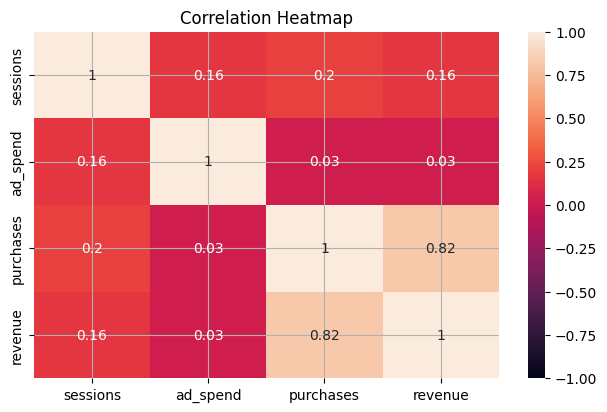

In [39]:

sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [47]:

# OLS with categorical region and (optionally) group
X = pd.get_dummies(df[["ad_spend","sessions","region","group"]], drop_first=True, dtype=int)
y = df["revenue"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
X

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.478
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           0.000497
Time:                        16:53:44   Log-Likelihood:                -3795.3
No. Observations:                 800   AIC:                             7603.
Df Residuals:                     794   BIC:                             7631.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.0809 

,const,ad_spend,sessions,region_Europe,region_North America,group_B
0,1.0,5.61,2,1,0,0
1,1.0,61.95,1,0,1,1
2,1.0,25.17,1,1,0,1
3,1.0,24.39,3,1,0,1
4,1.0,10.20,0,0,1,0
...,...,...,...,...,...,...
795,1.0,52.47,2,1,0,1
796,1.0,23.74,2,0,1,1
797,1.0,17.62,1,0,1,1
798,1.0,17.48,3,0,1,1


## 7) Business Framing & Communication

**Prompt (write 3–5 bullet points):**
- What *actionable* insight would you present to stakeholders?
- If A vs B shows a lift, estimate potential revenue impact (order‑of‑magnitude).
- What assumptions might break? What follow‑up analyses or data would you request?
- Propose a next step: iterate on the experiment, segment users, or launch?

> *Rubric hint:* Clear claim + evidence + caveats + next step.

In [50]:

# 👇 Write your 3–5 bullets here (as a Python multi-line string for easy export)
business_takeaways = """
- Example: Group B shows a statistically significant +$X mean revenue lift vs Group A (p < 0.05).
- Estimated impact: With N monthly users, expected monthly lift ≈ N * (delta_mean_revenue).
- Caveats: Revenue is heavy-tailed; validate with median and robust methods; check outliers.
- Next: Run a confirmatory test with pre-registered metrics and tighter guardrails.
"""
print(business_takeaways)


- Example: Group B shows a statistically significant +$X mean revenue lift vs Group A (p < 0.05).
- Estimated impact: With N monthly users, expected monthly lift ≈ N * (delta_mean_revenue).
- Caveats: Revenue is heavy-tailed; validate with median and robust methods; check outliers.
- Next: Run a confirmatory test with pre-registered metrics and tighter guardrails.



## Appendix — Helpers & Exports

In [ ]:
# Save any intermediate outputs
# corr.to_csv("correlations.csv", index=True)
# region_cis.to_csv("region_ci.csv")
# print("Saved: correlations.csv, region_ci.csv")

Saved: correlations.csv, region_ci.csv
